In [2]:

#  Imports + Reproducibility + Config
import os, re, random
import numpy as np
import matplotlib.pyplot as plt

import torch

from datasets import load_dataset

CFG = {
    "seed": 42,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "image_size": 224,

    # Baseline
    "top_k_answers": 500,
    "max_vocab": 20000,
    "max_q_len": 32,
    "baseline_batch": 64,
    "baseline_epochs": 12,
    "baseline_lr": 3e-4,

    # BLIP
    "blip_ckpt": "Salesforce/blip-vqa-base",
    "blip_batch": 2,
    "blip_epochs": 6,
    "blip_lr": 5e-5,
    "blip_wd": 0.01,
    "blip_warmup_ratio": 0.10,
    "max_answer_len": 16,
    "max_new_tokens_eval": 8,

    # Generate settings
    "num_beams": 3,
    "no_repeat_ngram_size": 2,
    "repetition_penalty": 1.15,
    "length_penalty": 0.8,
}

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CFG["seed"])
print("Device:", CFG["device"])


Device: cuda


In [ ]:
# Setup save directories (configurable paths)
SAVE_ROOT = os.environ.get("SAVE_ROOT", "./saved_models")
BASELINE_DIR = os.path.join(SAVE_ROOT, "baseline")
BLIP_DIR = os.path.join(SAVE_ROOT, "blip")

os.makedirs(BASELINE_DIR, exist_ok=True)
os.makedirs(BLIP_DIR, exist_ok=True)

print("Save root:", SAVE_ROOT)
print("Baseline dir:", BASELINE_DIR)
print("BLIP dir:", BLIP_DIR)

In [4]:

# 2) Load Dataset (SLAKE)
DATASET_NAME = "mdwiratathya/SLAKE-vqa-english"
ds = load_dataset(DATASET_NAME)
ds


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/31.1M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/12.2M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/8.34M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/9.59M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4919 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1053 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1061 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 4919
    })
    validation: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 1053
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 1061
    })
})

In [ ]:
# Text normalization
def normalize_text(s: str) -> str:
    s = str(s).lower().strip()
    s = re.sub(r"\s+", " ", s)

    # Keep useful medical symbols: / + - . : % ( ) < >
    s = re.sub(r"[^\w\s/\+\-\.:%%()<>]", "", s)

    # yes/no canonicalization
    if s in {"y", "yeah", "yep", "true", "positive"}:
        s = "yes"
    elif s in {"n", "nope", "false", "negative"}:
        s = "no"

    # light modality normalization
    s = s.replace("computed tomography", "ct")
    s = s.replace("magnetic resonance", "mri")
    s = s.replace("x ray", "x-ray")

    return s

def add_norm_fields(example):
    example["question_norm"] = normalize_text(example.get("question", ""))
    example["answer_norm"]   = normalize_text(example.get("answer", ""))
    return example

ds = ds.map(add_norm_fields)
print("Added question_norm + answer_norm")
print(ds)

In [6]:
#  Quick Data Preview
print("Train columns:", ds["train"].column_names)
x0 = ds["train"][0]
print({
    "question": x0["question"],
    "answer": x0["answer"],
    "question_norm": x0["question_norm"],
    "answer_norm": x0["answer_norm"],
})


Train columns: ['image', 'question', 'answer', 'question_norm', 'answer_norm']
{'question': 'What modality is used to take this image?', 'answer': 'MRI', 'question_norm': 'what modality is used to take this image', 'answer_norm': 'mri'}


In [7]:
# Basic dataset counts
split_counts = {k: len(ds[k]) for k in ds.keys()}
print("Split counts:", split_counts)
print("Total:", sum(split_counts.values()))


Split counts: {'train': 4919, 'validation': 1053, 'test': 1061}
Total: 7033


In [8]:
# Baseline: Build answer vocabulary (TRAIN only)
from collections import Counter

TOP_K = CFG["top_k_answers"]

train_answers = [x["answer_norm"] for x in ds["train"]]
cnt_train = Counter(train_answers)

most_common = cnt_train.most_common(TOP_K)
answer2id = {a: i for i, (a, _) in enumerate(most_common)}
unk_id = TOP_K
num_classes = TOP_K + 1

def encode_answer(example):
    example["label"] = answer2id.get(example["answer_norm"], unk_id)
    return example

ds_baseline = ds.map(encode_answer)

for split in ds_baseline.keys():
    labels = [x["label"] for x in ds_baseline[split]]
    unk_rate = sum(l == unk_id for l in labels) / len(labels)
    print(f"{split}: <unk> rate = {unk_rate:.3f}")

print("✅ num_classes:", num_classes)


Map:   0%|          | 0/4919 [00:00<?, ? examples/s]

Map:   0%|          | 0/1053 [00:00<?, ? examples/s]

Map:   0%|          | 0/1061 [00:00<?, ? examples/s]

train: <unk> rate = 0.000
validation: <unk> rate = 0.003
test: <unk> rate = 0.002
✅ num_classes: 501


In [9]:
# Baseline: Build question word vocab (TRAIN only)
MAX_VOCAB = CFG["max_vocab"]
MAX_Q_LEN = CFG["max_q_len"]

word_freq = Counter()
for x in ds_baseline["train"]:
    word_freq.update(x["question_norm"].split())

vocab_words = ["<pad>", "<unk>"] + [w for w, _ in word_freq.most_common(MAX_VOCAB - 2)]
word2id = {w: i for i, w in enumerate(vocab_words)}
pad_id, unk_wid = 0, 1

def encode_question(q_norm: str):
    toks = q_norm.split()[:MAX_Q_LEN]
    ids = [word2id.get(t, unk_wid) for t in toks]
    ids += [pad_id] * (MAX_Q_LEN - len(ids))
    return ids

print("✅ Question vocab size:", len(vocab_words))


✅ Question vocab size: 292


In [10]:
# Baseline: Dataset + Loaders
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

img_tfms = T.Compose([
    T.Resize((CFG["image_size"], CFG["image_size"])),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

class SlakeBaselineTorch(Dataset):
    def __init__(self, hf_ds):
        self.ds = hf_ds
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx):
        x = self.ds[idx]
        img = img_tfms(x["image"].convert("RGB"))
        q_ids = torch.tensor(encode_question(x["question_norm"]), dtype=torch.long)
        y = torch.tensor(x["label"], dtype=torch.long)
        return {"pixel_values": img, "q_ids": q_ids, "labels": y}

def make_baseline_loader(split, shuffle):
    dset = SlakeBaselineTorch(ds_baseline[split])
    return DataLoader(
        dset,
        batch_size=CFG["baseline_batch"],
        shuffle=shuffle,
        num_workers=2,
        pin_memory=True,
    )

baseline_train_loader = make_baseline_loader("train", True)
baseline_val_loader   = make_baseline_loader("validation", False)
baseline_test_loader  = make_baseline_loader("test", False)

print("✅ Baseline loaders ready")


✅ Baseline loaders ready


In [11]:
# Baseline: Class weights (imbalance)
from collections import Counter

train_labels = [x["label"] for x in ds_baseline["train"]]
label_counts = Counter(train_labels)

weights = torch.zeros(num_classes, dtype=torch.float)
for c in range(num_classes):
    weights[c] = 1.0 / (label_counts.get(c, 0) + 1.0)

weights = weights / weights.mean()
weights = weights.to(CFG["device"])

print("✅ weights ready | min:", float(weights.min()), "max:", float(weights.max()))


✅ weights ready | min: 0.0017323520733043551 max: 1.4984846115112305


In [12]:
#  Baseline Model (ResNet18 + BiLSTM)
from torch import nn
from torchvision.models import resnet18, ResNet18_Weights

class ResNetLSTMVQA(nn.Module):
    def __init__(self, num_classes, vocab_size, emb_dim=256, lstm_dim=256):
        super().__init__()
        self.cnn = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.cnn.fc = nn.Identity()  # 512

        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_id)
        self.lstm = nn.LSTM(emb_dim, lstm_dim, batch_first=True, bidirectional=True)

        self.head = nn.Sequential(
            nn.Linear(512 + 2*lstm_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes),
        )

    def forward(self, pixel_values, q_ids):
        img_feat = self.cnn(pixel_values)
        q_emb = self.emb(q_ids)
        _, (h, _) = self.lstm(q_emb)
        q_feat = torch.cat([h[0], h[1]], dim=-1)
        return self.head(torch.cat([img_feat, q_feat], dim=-1))

baseline_model = ResNetLSTMVQA(num_classes=num_classes, vocab_size=len(vocab_words)).to(CFG["device"])
print("✅ Baseline model ready")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


✅ Baseline model ready


In [ ]:
# Baseline Train + Save BEST
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

def eval_baseline(model, loader):
    model.eval()
    ce = nn.CrossEntropyLoss(weight=weights)
    ys, ps = [], []
    total_loss, n = 0.0, 0

    with torch.no_grad():
        for b in loader:
            pv = b["pixel_values"].to(CFG["device"], non_blocking=True)
            q  = b["q_ids"].to(CFG["device"], non_blocking=True)
            y  = b["labels"].to(CFG["device"], non_blocking=True)

            logits = model(pv, q)
            loss = ce(logits, y)

            total_loss += loss.item() * y.size(0)
            n += y.size(0)

            ps.extend(torch.argmax(logits, dim=-1).cpu().tolist())
            ys.extend(y.cpu().tolist())

    return {
        "loss": total_loss / n,
        "acc": accuracy_score(ys, ps),
        "macro_f1": f1_score(ys, ps, average="macro"),
    }

def train_baseline(model, epochs=12, lr=3e-4):
    local_path = os.path.join(BASELINE_DIR, "baseline_best.pt")

    opt = AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    sched = CosineAnnealingLR(opt, T_max=epochs)
    ce = nn.CrossEntropyLoss(weight=weights)

    best_acc = -1.0
    patience = 3
    bad = 0

    for epoch in range(1, epochs + 1):
        model.train()
        pbar = tqdm(baseline_train_loader, desc=f"Baseline Epoch {epoch}/{epochs}")

        for b in pbar:
            pv = b["pixel_values"].to(CFG["device"], non_blocking=True)
            q  = b["q_ids"].to(CFG["device"], non_blocking=True)
            y  = b["labels"].to(CFG["device"], non_blocking=True)

            opt.zero_grad(set_to_none=True)
            logits = model(pv, q)
            loss = ce(logits, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            pbar.set_postfix(loss=float(loss.item()))

        sched.step()

        val = eval_baseline(model, baseline_val_loader)
        print("VAL:", val)

        if val["acc"] > best_acc:
            best_acc = val["acc"]
            bad = 0
            ckpt = {
                "model": model.state_dict(),
                "answer2id": answer2id,
                "word2id": word2id,
                "cfg": CFG
            }
            torch.save(ckpt, local_path)
            print("Saved BEST baseline:", local_path)
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping baseline.")
                break

train_baseline(baseline_model, epochs=CFG["baseline_epochs"], lr=CFG["baseline_lr"])

# Evaluate baseline on test
baseline_ckpt = torch.load(os.path.join(BASELINE_DIR, "baseline_best.pt"), map_location=CFG["device"])
baseline_model.load_state_dict(baseline_ckpt["model"])
baseline_model.to(CFG["device"]).eval()

baseline_test = eval_baseline(baseline_model, baseline_test_loader)
print("Baseline TEST:", baseline_test)

In [ ]:
# BLIP Setup (Processor + Model)
from transformers import BlipProcessor, BlipForQuestionAnswering

processor = BlipProcessor.from_pretrained(CFG["blip_ckpt"])
blip_model = BlipForQuestionAnswering.from_pretrained(CFG["blip_ckpt"]).to(CFG["device"])
print("Loaded BLIP:", CFG["blip_ckpt"])

In [ ]:
# BLIP: Choose trainable parts
for p in blip_model.parameters():
    p.requires_grad = False

for name, p in blip_model.named_parameters():
    if name.startswith("text_encoder.") or name.startswith("text_decoder."):
        p.requires_grad = True

trainable_params = sum(p.numel() for p in blip_model.parameters() if p.requires_grad)
print("Trainable BLIP params:", trainable_params / 1e6, "M")

In [16]:
#  BLIP Dataset + Collate (NO CUDA ASSERT / SAFE)
from torch.utils.data import Dataset, DataLoader

class SlakeBLIPTorch(Dataset):
    def __init__(self, hf_ds):
        self.ds = hf_ds
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx):
        x = self.ds[idx]
        return {
            "image": x["image"].convert("RGB"),
            "question": x["question_norm"],
            "answer": x["answer_norm"],
        }

def blip_collate(batch):
    images = [b["image"] for b in batch]
    questions = [b["question"] for b in batch]
    answers = [b["answer"] for b in batch]

    enc = processor(
        images=images,
        text=questions,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )

    labels_input_ids = processor.tokenizer(
        answers,
        padding=True,
        truncation=True,
        max_length=CFG["max_answer_len"],
        return_tensors="pt"
    )["input_ids"]

    pad_id = processor.tokenizer.pad_token_id

    # loss_labels masks PAD only
    loss_labels = labels_input_ids.clone()
    loss_labels[loss_labels == pad_id] = -100

    # decoder_input_ids shift-right (safe)
    start_id = processor.tokenizer.bos_token_id
    if start_id is None:
        start_id = processor.tokenizer.cls_token_id

    decoder_input_ids = labels_input_ids.clone()
    decoder_input_ids[:, 1:] = labels_input_ids[:, :-1]
    decoder_input_ids[:, 0] = start_id

    return {
        "pixel_values": enc["pixel_values"],
        "q_ids": enc["input_ids"],
        "decoder_input_ids": decoder_input_ids,
        "labels": loss_labels,
    }

def make_blip_loader(split, shuffle):
    return DataLoader(
        SlakeBLIPTorch(ds[split]),
        batch_size=CFG["blip_batch"],
        shuffle=shuffle,
        num_workers=0,
        pin_memory=False,   # ✅ avoid pin_memory CUDA assert
        collate_fn=blip_collate
    )

blip_train_loader = make_blip_loader("train", True)
blip_val_loader   = make_blip_loader("validation", False)
blip_test_loader  = make_blip_loader("test", False)

b = next(iter(blip_train_loader))
print("✅ BLIP loaders OK | shapes:",
      b["pixel_values"].shape,
      b["q_ids"].shape,
      b["decoder_input_ids"].shape,
      b["labels"].shape)


✅ BLIP loaders OK | shapes: torch.Size([2, 3, 384, 384]) torch.Size([2, 13]) torch.Size([2, 4]) torch.Size([2, 4])


In [17]:
# BLIP Metrics (EM + TokenF1 + yes/no split)
from collections import Counter
from tqdm import tqdm

def token_f1(pred: str, gt: str) -> float:
    p = normalize_text(pred).split()
    g = normalize_text(gt).split()

    if len(p) == 0 and len(g) == 0:
        return 1.0
    if len(p) == 0 or len(g) == 0:
        return 0.0

    pc, gc = Counter(p), Counter(g)
    overlap = sum((pc & gc).values())
    if overlap == 0:
        return 0.0

    prec = overlap / len(p)
    rec  = overlap / len(g)
    return 2 * prec * rec / (prec + rec)

@torch.inference_mode()
def blip_eval_metrics(model, loader, max_new_tokens=8):
    model.eval()
    pad_id = processor.tokenizer.pad_token_id

    em_hits = 0
    f1_sum = 0.0
    n = 0

    yesno_em_hits = 0
    yesno_n = 0
    other_em_hits = 0
    other_n = 0

    for batch in tqdm(loader, desc="Eval(metrics)", leave=False):
        batch = {k: v.to(CFG["device"], non_blocking=True) for k, v in batch.items()}

        input_ids = batch["q_ids"]
        attention_mask = (input_ids != pad_id).long()

        gen_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=batch["pixel_values"],
            max_new_tokens=max_new_tokens,
            do_sample=False,
            num_beams=CFG["num_beams"],
            no_repeat_ngram_size=CFG["no_repeat_ngram_size"],
            repetition_penalty=CFG["repetition_penalty"],
            length_penalty=CFG["length_penalty"],
            early_stopping=True
        )

        preds = processor.tokenizer.batch_decode(gen_ids, skip_special_tokens=True)
        preds = [normalize_text(t) for t in preds]

        # decode labels safely (replace -100 -> pad)
        labels = batch["labels"].clone()
        labels[labels == -100] = pad_id
        refs = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)
        refs = [normalize_text(t) for t in refs]

        for p, r in zip(preds, refs):
            n += 1
            em = int(p == r)
            em_hits += em
            f1_sum += token_f1(p, r)

            if r in {"yes", "no"}:
                yesno_n += 1
                yesno_em_hits += em
            else:
                other_n += 1
                other_em_hits += em

    return {
        "EM": em_hits / max(1, n),
        "Token_F1": f1_sum / max(1, n),
        "YesNo_EM": yesno_em_hits / max(1, yesno_n),
        "Other_EM": other_em_hits / max(1, other_n),
        "N": n,
        "YesNo_N": yesno_n,
        "Other_N": other_n,
    }


In [ ]:
# Train BLIP + Save BEST
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

def train_blip(model, epochs=4):
    local_path = os.path.join(BLIP_DIR, "blip_best.pt")

    trainable_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = AdamW(trainable_params, lr=CFG["blip_lr"], weight_decay=CFG["blip_wd"])

    steps_per_epoch = len(blip_train_loader)
    total_steps = steps_per_epoch * epochs
    warmup_steps = int(total_steps * CFG["blip_warmup_ratio"])

    scheduler = get_linear_schedule_with_warmup(
        optimizer, warmup_steps, total_steps
    )

    pad_id = processor.tokenizer.pad_token_id
    best_val_em = -1.0

    for epoch in range(1, epochs + 1):
        model.train()
        pbar = tqdm(blip_train_loader, desc=f"BLIP Epoch {epoch}/{epochs}")
        total_loss = 0.0

        for batch in pbar:
            batch = {k: v.to(CFG["device"]) for k, v in batch.items()}

            input_ids = batch["q_ids"]
            attention_mask = (input_ids != pad_id).long()

            optimizer.zero_grad(set_to_none=True)

            out = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                pixel_values=batch["pixel_values"],
                decoder_input_ids=batch["decoder_input_ids"],
                labels=batch["labels"]
            )

            loss = out.loss
            loss.backward()

            torch.nn.utils.clip_grad_norm_(trainable_params, 1.0)

            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=float(loss.item()))

        avg_loss = total_loss / max(1, len(blip_train_loader))
        print(f"\nEpoch {epoch} Train Loss: {avg_loss:.4f}")

        val_metrics = blip_eval_metrics(model, blip_val_loader, max_new_tokens=5)
        print(f"Epoch {epoch} VAL metrics:", val_metrics)

        if val_metrics["EM"] > best_val_em:
            best_val_em = val_metrics["EM"]
            ckpt = {"model": model.state_dict(), "cfg": CFG}

            torch.save(ckpt, local_path)
            print("Saved BEST BLIP:", local_path)

    print("\nTraining finished.")
    print("Best VAL EM:", best_val_em)

train_blip(blip_model, epochs=CFG["blip_epochs"])

In [ ]:
# Load BLIP best + Test evaluation
best_path = os.path.join(BLIP_DIR, "blip_best.pt")
ckpt = torch.load(best_path, map_location=CFG["device"])

blip_model.load_state_dict(ckpt["model"])
blip_model.to(CFG["device"]).eval()

print("Loaded BLIP best from:", best_path)

test_metrics = blip_eval_metrics(blip_model, blip_test_loader, max_new_tokens=CFG["max_new_tokens_eval"])
print("BLIP TEST metrics:", test_metrics)

In [20]:
# Final BLIP inference + Error display

@torch.inference_mode()
def blip_infer_final(image, question, max_new_tokens=8):
    inputs = processor(images=image, text=question, padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.to(CFG["device"]) for k, v in inputs.items()}
    attn = (inputs["input_ids"] != processor.tokenizer.pad_token_id).long()

    gen_ids = blip_model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=attn,
        pixel_values=inputs["pixel_values"],
        max_new_tokens=max_new_tokens,
        do_sample=False,
        num_beams=CFG["num_beams"],
        no_repeat_ngram_size=CFG["no_repeat_ngram_size"],
        repetition_penalty=CFG["repetition_penalty"],
        length_penalty=CFG["length_penalty"],
        early_stopping=True
    )
    pred = processor.tokenizer.decode(gen_ids[0], skip_special_tokens=True)
    return normalize_text(pred)

import random

def show_errors(k=10):
    idxs = random.sample(range(len(ds["test"])), min(k*6, len(ds["test"])))
    shown = 0
    for i in idxs:
        s = ds["test"][i]
        q, gt = s["question_norm"], s["answer_norm"]
        pr = blip_infer_final(s["image"], q)
        if pr != gt:
            print("-"*50)
            print("Q :", q)
            print("GT:", gt)
            print("PR:", pr)
            shown += 1
            if shown >= k:
                break

show_errors(10)


--------------------------------------------------
Q : where is/are the abnormality located
GT: left lung lower right
PR: left right left
--------------------------------------------------
Q : what disease is/are shown on the lower left of lung
GT: pulmonary infiltration
PR: cardega
--------------------------------------------------
Q : where is/are the abnormality located
GT: center
PR: left right
--------------------------------------------------
Q : what diseases are included in the picture
GT: none
PR: lung
--------------------------------------------------
Q : which plane is the image scanned transverse plane or coronal plane
GT: coronal plane
PR: corona plane
--------------------------------------------------
Q : which organs/organ is part of the circulatory system in this image
GT: heart
PR: heart liver
--------------------------------------------------
Q : what is the main cause of the disease on the upper left lobe of brain in this picture
GT: brain embryonic tissue dysplasia 

In [21]:
# Compare Baseline vs BLIP (Test Metrics + Summary Table)
import pandas as pd

# Evaluate Baseline on TEST
baseline_test_metrics = eval_baseline(baseline_model, baseline_test_loader)
print("✅ Baseline TEST:", baseline_test_metrics)

# Evaluate BLIP on TEST
blip_test_metrics = blip_eval_metrics(blip_model, blip_test_loader, max_new_tokens=CFG["max_new_tokens_eval"])
print("✅ BLIP TEST:", blip_test_metrics)

# Make comparison table
comparison = pd.DataFrame([
    {
        "Model": "Baseline (ResNet18+BiLSTM)",
        "Test_Accuracy": baseline_test_metrics["acc"],
        "Test_MacroF1": baseline_test_metrics["macro_f1"],
        "Test_Loss": baseline_test_metrics["loss"],
        "Test_EM": None,
        "Test_TokenF1": None,
        "YesNo_EM": None,
        "Other_EM": None
    },
    {
        "Model": "BLIP (FT text encoder+decoder)",
        "Test_Accuracy": None,
        "Test_MacroF1": None,
        "Test_Loss": None,
        "Test_EM": blip_test_metrics["EM"],
        "Test_TokenF1": blip_test_metrics["Token_F1"],
        "YesNo_EM": blip_test_metrics["YesNo_EM"],
        "Other_EM": blip_test_metrics["Other_EM"]
    }
])

display(comparison)


✅ Baseline TEST: {'loss': 2.2980339220399344, 'acc': 0.6107445805843544, 'macro_f1': 0.3690702128068983}


✅ BLIP TEST: {'EM': 0.6409048067860509, 'Token_F1': 0.7120152426162291, 'YesNo_EM': 0.8647887323943662, 'Other_EM': 0.5283286118980169, 'N': 1061, 'YesNo_N': 355, 'Other_N': 706}


,Model,Test_Accuracy,Test_MacroF1,Test_Loss,Test_EM,Test_TokenF1,YesNo_EM,Other_EM
0,Baseline (ResNet18+BiLSTM),0.610745,0.36907,2.298034,NaN,NaN,NaN,NaN
1,BLIP (FT text encoder+decoder),NaN,NaN,NaN,0.640905,0.712015,0.864789,0.528329


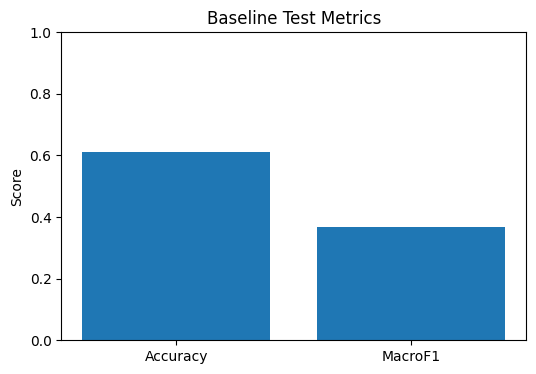

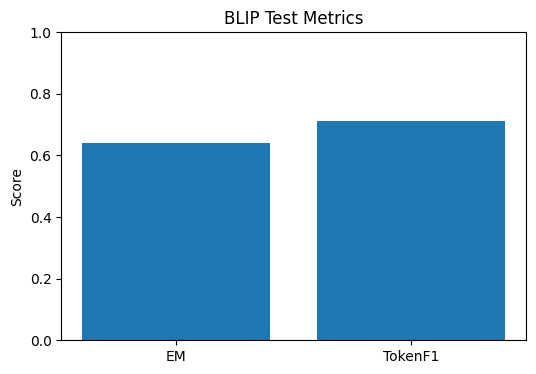

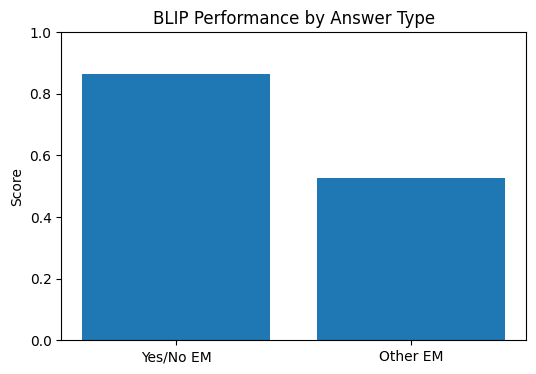

In [22]:
#  Plot Comparison (Baseline vs BLIP)
import matplotlib.pyplot as plt
import numpy as np

# Prepare values for plotting
models = ["Baseline", "BLIP"]
baseline_vals = {
    "Accuracy": baseline_test_metrics["acc"],
    "MacroF1": baseline_test_metrics["macro_f1"]
}
blip_vals = {
    "EM": blip_test_metrics["EM"],
    "TokenF1": blip_test_metrics["Token_F1"]
}

# Plot baseline metrics
plt.figure(figsize=(6,4))
plt.bar(["Accuracy", "MacroF1"], [baseline_vals["Accuracy"], baseline_vals["MacroF1"]])
plt.ylim(0, 1)
plt.title("Baseline Test Metrics")
plt.ylabel("Score")
plt.show()

# Plot blip metrics
plt.figure(figsize=(6,4))
plt.bar(["EM", "TokenF1"], [blip_vals["EM"], blip_vals["TokenF1"]])
plt.ylim(0, 1)
plt.title("BLIP Test Metrics")
plt.ylabel("Score")
plt.show()

# Extra: Yes/No vs Other performance for BLIP
plt.figure(figsize=(6,4))
plt.bar(["Yes/No EM", "Other EM"], [blip_test_metrics["YesNo_EM"], blip_test_metrics["Other_EM"]])
plt.ylim(0, 1)
plt.title("BLIP Performance by Answer Type")
plt.ylabel("Score")
plt.show()


In [23]:
# Simple Final Comparison Print (Readable Summary)
print("\n" + "="*60)
print(" FINAL COMPARISON SUMMARY")
print("="*60)

print("\n Baseline (ResNet18+BiLSTM) TEST:")
print(f" - Accuracy : {baseline_test_metrics['acc']:.4f}")
print(f" - Macro-F1 : {baseline_test_metrics['macro_f1']:.4f}")
print(f" - Loss     : {baseline_test_metrics['loss']:.4f}")

print("\n BLIP (Fine-tuned) TEST:")
print(f" - EM        : {blip_test_metrics['EM']:.4f}")
print(f" - Token-F1  : {blip_test_metrics['Token_F1']:.4f}")
print(f" - Yes/No EM : {blip_test_metrics['YesNo_EM']:.4f}")
print(f" - Other EM  : {blip_test_metrics['Other_EM']:.4f}")
print("="*60)



 FINAL COMPARISON SUMMARY

 Baseline (ResNet18+BiLSTM) TEST:
 - Accuracy : 0.6107
 - Macro-F1 : 0.3691
 - Loss     : 2.2980

 BLIP (Fine-tuned) TEST:
 - EM        : 0.6409
 - Token-F1  : 0.7120
 - Yes/No EM : 0.8648
 - Other EM  : 0.5283


In [24]:
# Fair Comparison: Baseline vs BLIP on YES/NO questions only
import numpy as np
import random
import torch

YESNO_SET = {"yes", "no"}

def get_baseline_pred_text(sample):
    """
    Baseline predicts a class ID -> convert it back to answer text.
    """
    # reverse mapping for baseline answers
    id2answer = {v: k for k, v in answer2id.items()}
    id2answer[unk_id] = "<unk>"

    # prepare tensors
    img = img_tfms(sample["image"].convert("RGB")).unsqueeze(0).to(CFG["device"])
    q_ids = torch.tensor(encode_question(sample["question_norm"]), dtype=torch.long).unsqueeze(0).to(CFG["device"])

    baseline_model.eval()
    with torch.no_grad():
        logits = baseline_model(img, q_ids)
        pred_id = int(torch.argmax(logits, dim=-1).item())

    pred_text = id2answer.get(pred_id, "<unk>")
    return normalize_text(pred_text)

def fair_eval_yesno(n=300, seed=42):
    """
    Compare Baseline and BLIP fairly on YES/NO subset only.
    Metric = Exact Match (accuracy)
    """
    random.seed(seed)

    # collect yes/no indices
    yesno_idxs = []
    for i in range(len(ds["test"])):
        gt = normalize_text(ds["test"][i]["answer_norm"])
        if gt in YESNO_SET:
            yesno_idxs.append(i)

    if len(yesno_idxs) == 0:
        print(" No yes/no samples found in test set.")
        return

    # sample subset
    n = min(n, len(yesno_idxs))
    chosen = random.sample(yesno_idxs, n)

    baseline_correct = 0
    blip_correct = 0

    for idx in chosen:
        # BLIP uses ds["test"]
        s_blip = ds["test"][idx]
        gt = normalize_text(s_blip["answer_norm"])

        # BLIP pred
        pr_blip = blip_infer_final(s_blip["image"], s_blip["question_norm"])
        pr_blip = normalize_text(pr_blip)

        # Baseline uses ds_baseline (same index order)
        s_base = ds_baseline["test"][idx]
        pr_base = get_baseline_pred_text(s_blip)  # use same sample content

        baseline_correct += int(pr_base == gt)
        blip_correct += int(pr_blip == gt)

    baseline_acc = baseline_correct / n
    blip_acc = blip_correct / n

    print("\n" + "="*60)
    print(" FAIR YES/NO COMPARISON (Exact Match Accuracy)")
    print("="*60)
    print(f"Total YES/NO samples evaluated: {n}")
    print(f"Baseline YES/NO Accuracy: {baseline_acc:.4f}")
    print(f"BLIP YES/NO Accuracy    : {blip_acc:.4f}")
    print("="*60)

fair_eval_yesno(n=300, seed=CFG["seed"])



 FAIR YES/NO COMPARISON (Exact Match Accuracy)
Total YES/NO samples evaluated: 300
Baseline YES/NO Accuracy: 0.4800
BLIP YES/NO Accuracy    : 0.8600


In [25]:
# Fair Comparison: Baseline vs BLIP on TOP-K answers only
import random
import torch
import numpy as np

def get_baseline_pred_text(sample):
    """
    Baseline predicts class id -> convert to answer text using answer2id.
    """
    id2answer = {v: k for k, v in answer2id.items()}
    id2answer[unk_id] = "<unk>"

    img = img_tfms(sample["image"].convert("RGB")).unsqueeze(0).to(CFG["device"])
    q_ids = torch.tensor(encode_question(sample["question_norm"]), dtype=torch.long).unsqueeze(0).to(CFG["device"])

    baseline_model.eval()
    with torch.no_grad():
        logits = baseline_model(img, q_ids)
        pred_id = int(torch.argmax(logits, dim=-1).item())

    return normalize_text(id2answer.get(pred_id, "<unk>"))

def fair_eval_topk(n=500, seed=42):
    """
    Fair compare between Baseline and BLIP only on test samples where
    GT answer is within baseline's Top-K vocabulary (not <unk>).

    Metric = Exact Match on normalized answer strings.
    """
    random.seed(seed)

    eligible = []
    for i in range(len(ds_baseline["test"])):
        if ds_baseline["test"][i]["label"] != unk_id:  # GT in Top-K
            eligible.append(i)

    if len(eligible) == 0:
        print(" No Top-K eligible samples found.")
        return

    n = min(n, len(eligible))
    chosen = random.sample(eligible, n)

    base_correct = 0
    blip_correct = 0

    for idx in chosen:
        s = ds["test"][idx]
        gt = normalize_text(s["answer_norm"])

        # Baseline prediction (classification -> text)
        pr_base = get_baseline_pred_text(s)

        # BLIP prediction (generation -> text)
        pr_blip = normalize_text(blip_infer_final(s["image"], s["question_norm"]))

        base_correct += int(pr_base == gt)
        blip_correct += int(pr_blip == gt)

    base_acc = base_correct / n
    blip_acc = blip_correct / n

    print("\n" + "="*60)
    print("FAIR TOP-K COMPARISON (Exact Match)")
    print("="*60)
    print(f"Eligible samples (GT in Top-K): {len(eligible)}")
    print(f"Evaluated subset: {n}")
    print(f"Baseline Top-K EM: {base_acc:.4f}")
    print(f"BLIP Top-K EM    : {blip_acc:.4f}")
    print("="*60)

fair_eval_topk(n=500, seed=CFG["seed"])



FAIR TOP-K COMPARISON (Exact Match)
Eligible samples (GT in Top-K): 1059
Evaluated subset: 500
Baseline Top-K EM: 0.6100
BLIP Top-K EM    : 0.6460


In [30]:
# Show Top-K Errors: Baseline vs BLIP (Side-by-side)
import random
import torch

def get_baseline_pred_text(sample):

    id2answer = {v: k for k, v in answer2id.items()}
    id2answer[unk_id] = "<unk>"

    img = img_tfms(sample["image"].convert("RGB")).unsqueeze(0).to(CFG["device"])
    q_ids = torch.tensor(encode_question(sample["question_norm"]), dtype=torch.long).unsqueeze(0).to(CFG["device"])

    baseline_model.eval()
    with torch.no_grad():
        logits = baseline_model(img, q_ids)
        pred_id = int(torch.argmax(logits, dim=-1).item())

    return normalize_text(id2answer.get(pred_id, "<unk>"))

def show_topk_errors(k=15, seed=42):

    random.seed(seed)

    # collect eligible indices (GT inside top-k)
    eligible = []
    for i in range(len(ds_baseline["test"])):
        if ds_baseline["test"][i]["label"] != unk_id:
            eligible.append(i)

    if len(eligible) == 0:
        print(" No Top-K eligible samples found.")
        return

    # sample more than k to find enough mistakes
    idxs = random.sample(eligible, min(len(eligible), k * 10))

    shown = 0
    for idx in idxs:
        s = ds["test"][idx]
        q = s["question_norm"]
        gt = normalize_text(s["answer_norm"])

        pr_base = get_baseline_pred_text(s)
        pr_blip = normalize_text(blip_infer_final(s["image"], q))

        # show only when at least one model is wrong
        if (pr_base != gt) or (pr_blip != gt):
            print("=" * 70)
            print(f"Index: {idx}")
            print("Q :", q)
            print("GT:", gt)
            print("Baseline:", pr_base, "" if pr_base == gt else "")
            print("BLIP    :", pr_blip, "" if pr_blip == gt else "")

            # Helpful quick label:
            if pr_base != gt and pr_blip == gt:
                print(" BLIP correct, Baseline wrong")
            elif pr_base == gt and pr_blip != gt:
                print(" Baseline correct, BLIP wrong")
            else:
                print(" Both wrong")

            shown += 1
            if shown >= k:
                break

    if shown == 0:
        print(" No mistakes found in the sampled subset (try increasing k).")

show_topk_errors(k=15, seed=CFG["seed"])


Index: 230
Q : does the picture contain liver
GT: no
Baseline: yes 
BLIP    : yes 
 Both wrong
Index: 52
Q : does the lung look healthy
GT: no
Baseline: yes 
BLIP    : no 
 BLIP correct, Baseline wrong
Index: 503
Q : is the lung abnormal
GT: yes
Baseline: no 
BLIP    : yes 
 BLIP correct, Baseline wrong
Index: 459
Q : can nodule be observed on the upper right lung in this picture
GT: yes
Baseline: yes 
BLIP    : no 
 Baseline correct, BLIP wrong
Index: 211
Q : where is/are the abnormality located
GT: liver
Baseline: liver left 
BLIP    : liver 
 BLIP correct, Baseline wrong
Index: 180
Q : where is the liver
GT: left
Baseline: upper left 
BLIP    : left top 
 Both wrong
Index: 866
Q : what is the effect of the organ on the upper left of this image
GT: biotransformation detoxification
Baseline: absorb water excrete body waste 
BLIP    : absorb watercre body 
 Both wrong
Index: 66
Q : which organ is abnormal heart or lung
GT: heart
Baseline: lung 
BLIP    : lung 
 Both wrong
Index: 193
Q 

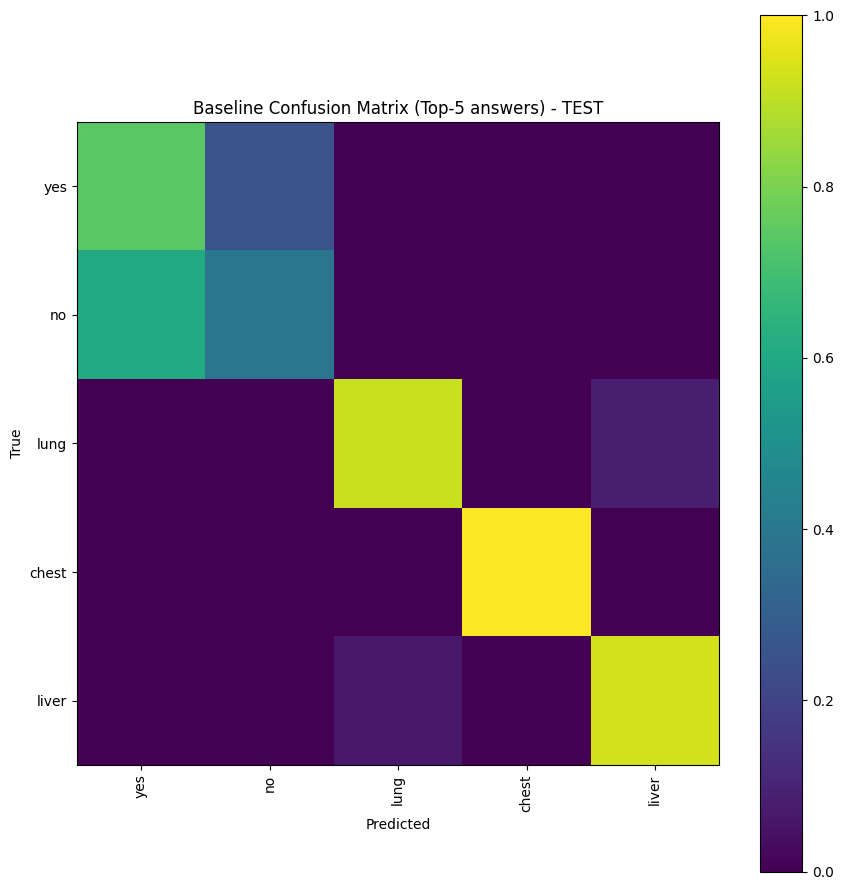

 Confusion matrix computed on:
 - total test samples: 1061
 - filtered samples (GT in topN): 494
 - <unk> ignored


In [31]:
# Confusion Matrix (Baseline) on TEST (Top-N answers)
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

@torch.inference_mode()
def baseline_get_preds_labels(loader):

    baseline_model.eval()
    y_true, y_pred = [], []

    for batch in loader:
        pv = batch["pixel_values"].to(CFG["device"], non_blocking=True)
        q  = batch["q_ids"].to(CFG["device"], non_blocking=True)
        y  = batch["labels"].to(CFG["device"], non_blocking=True)

        logits = baseline_model(pv, q)
        pred = torch.argmax(logits, dim=-1)

        y_true.extend(y.cpu().numpy().tolist())
        y_pred.extend(pred.cpu().numpy().tolist())

    return y_true, y_pred

def plot_confusion_matrix_topN(
    loader,
    topN=20,
    ignore_unk=True,
    normalize="true"  # "true" = normalize rows, None = raw counts
):

    # Build id -> answer text for baseline
    id2answer = {v: k for k, v in answer2id.items()}
    id2answer[unk_id] = "<unk>"

    # Get predictions and labels
    y_true, y_pred = baseline_get_preds_labels(loader)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Select top-N classes from TRAIN distribution
    # We already built most_common earlier (TOP_K list), take first topN
    top_ids = [answer2id[a] for a, _ in most_common[:topN]]

    # Optionally remove <unk>
    if ignore_unk and (unk_id in top_ids):
        top_ids = [i for i in top_ids if i != unk_id]

    # Keep only rows where GT in top_ids (so confusion focuses on frequent classes)
    mask = np.isin(y_true, top_ids)
    y_true_f = y_true[mask]
    y_pred_f = y_pred[mask]

    # If ignoring unk, also filter predictions that are unk (optional)
    if ignore_unk:
        keep = (y_pred_f != unk_id)
        y_true_f = y_true_f[keep]
        y_pred_f = y_pred_f[keep]

    # Map labels to compact indices [0..len(top_ids)-1]
    id_to_compact = {cid: i for i, cid in enumerate(top_ids)}
    y_true_c = np.array([id_to_compact[x] for x in y_true_f])
    y_pred_c = np.array([id_to_compact.get(x, -1) for x in y_pred_f])

    # Remove preds not in top_ids (mapped to -1)
    valid = (y_pred_c != -1)
    y_true_c = y_true_c[valid]
    y_pred_c = y_pred_c[valid]

    labels_text = [id2answer[cid] for cid in top_ids]

    cm = confusion_matrix(y_true_c, y_pred_c, labels=list(range(len(top_ids))), normalize=normalize)

    plt.figure(figsize=(1.0*len(top_ids) + 4, 1.0*len(top_ids) + 4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Baseline Confusion Matrix (Top-{len(top_ids)} answers) - TEST")
    plt.colorbar()

    tick_marks = np.arange(len(labels_text))
    plt.xticks(tick_marks, labels_text, rotation=90)
    plt.yticks(tick_marks, labels_text)

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    print(" Confusion matrix computed on:")
    print(f" - total test samples: {len(y_true)}")
    print(f" - filtered samples (GT in topN): {len(y_true_f)}")
    if ignore_unk:
        print(" - <unk> ignored")

# Run it:
plot_confusion_matrix_topN(
    baseline_test_loader,
    topN=5,
    ignore_unk=True,
    normalize="true"
)
